In [90]:
#DTW calculation

import pandas as pd
import numpy as np
import os
import glob 
import pickle
from math import *
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
from dtw import dtw
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
# from quatrotate import qv_mult # this routine implements rotation via quaternion multiplication

%matplotlib inline

In [91]:
def find_contiguous_colors(colors):
    # finds the continuous segments of colors and returns those segments
    segs = []
    curr_seg = []
    prev_color = ''
    for c in colors:
        if c == prev_color or prev_color == '':
            curr_seg.append(c)
        else:
            segs.append(curr_seg)
            curr_seg = []
            curr_seg.append(c)
        prev_color = c
    segs.append(curr_seg) # the final one
    return segs
 
def plot_multicolored_lines(x,y,colors):
    segments = find_contiguous_colors(colors)
    plt.figure(figsize=(20,4))
    start= 0
    for seg in segments:
        end = start + len(seg)
        l, = plt.gca().plot(x[start-1:end+1],y[start-1:end+1],lw=2,c=seg[0]) 
        start = end

In [92]:
# Function to map the colors as a list from the input list of x variables
def color_mapping(lst):
    cols=[]
    colors = {'ST':'blue', 'LT':'red','RT':'green'}
    for l in lst:
        cols.append(colors[l])      
    return cols

In [93]:
def GaussianFilter(df, window_length):
    df1 = df
    
    df1['AX'] = gaussian_filter(df['AX'], window_length)
    df1['AY'] = gaussian_filter(df['AY'], window_length)
    df1['AZ'] = gaussian_filter(df['AZ'], window_length)

    df1['GX'] = gaussian_filter(df['GX'], window_length)
    df1['GY'] = gaussian_filter(df['GY'], window_length)
    df1['GZ'] = gaussian_filter(df['GZ'], window_length)
    
    df1['AX1'] = gaussian_filter(df['AX1'], window_length)
    df1['AY1'] = gaussian_filter(df['AY1'], window_length)
    df1['AZ1'] = gaussian_filter(df['AZ1'], window_length)

    df1['GX1'] = gaussian_filter(df['GX1'], window_length)
    df1['GY1'] = gaussian_filter(df['GY1'], window_length)
    df1['GZ1'] = gaussian_filter(df['GZ1'], window_length)
    return df1

In [94]:
def Mean(df, input_features, out_feature):
    df[out_feature] = (df[input_features[0]] + df[input_features[1]]  + df[input_features[2]])/3
    
    return df
    
    

In [95]:
def Yaw_Roll_Pitch(df):
    roll  = []
    pitch = []
    yaw   = []
    for i in range(len(df)):
        x = df['AX'][i]
        y = df['AY'][i]
        z = df['AZ'][i]
        roll1 = atan(y/z)*57.3
        pitch1= atan((-x/(y*y + z*z)**(1/2)))*57.3
        yaw1  = atan((z/((x*x + z*z)**(1/2))))*57.3
        
        roll.append(roll1)
        pitch.append(pitch1)
        yaw.append(yaw1)
    
    df['orientX'] = pitch
    df['orientY'] = roll
    df['orientZ'] = yaw

In [96]:
def getQuat(df):

        """ Given 3 orientation angles, compute the quaternion. """

        yaw   = df['orientZ'] / 2. * np.pi / 180
        roll  = df['orientX'] / 2. * np.pi / 180
        pitch = df['orientY'] / 2. * np.pi / 180

        w =  np.cos(roll) * np.cos(pitch) * np.cos(yaw) + \
                np.sin(roll) * np.sin(pitch) * np.sin(yaw)

        x =  np.sin(roll) * np.cos(pitch) * np.cos(yaw) - \
                np.cos(roll) * np.sin(pitch) * np.sin(yaw)

        y =  np.cos(roll) * np.sin(pitch) * np.cos(yaw) + \
                np.sin(roll) * np.cos(pitch) * np.sin(yaw)

        z =  np.cos(roll) * np.cos(pitch) * np.sin(yaw) - \
                np.sin(roll) * np.sin(pitch) * np.cos(yaw)

        return w, x, y, z

In [97]:
"""
Rotate a 3D vector using the axis-angle method (quaternions).
"""

import numpy as np


def normalize(v, tolerance=0.00001):
    mag2 = sum(n * n for n in v)
    if abs(mag2 - 1.0) > tolerance:
        mag = np.sqrt(mag2)
        v = tuple(n / mag for n in v)
    return v

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return w, x, y, z

def q_conjugate(q):
    w, x, y, z = q
    return (w, -x, -y, -z)

def qv_mult(q1, v1):
    q2 = (0.0,) + v1
    return q_mult(q_mult(q1, q2), q_conjugate(q1))[1:]

def axisangle_to_q(v, theta):
    v = normalize(v)
    x, y, z = v
    theta /= 2
    w = np.cos(theta)
    x = x * np.sin(theta)
    y = y * np.sin(theta)
    z = z * np.sin(theta)
    return w, x, y, z

def q_to_axisangle(q):
    w, v = q[0], q[1:]
    theta = np.acos(w) * 2.0
    return normalize(v), theta

In [98]:
def get_rotation(quatern, vector):
    rotaedvector = []
    for i in range(vector.shape[0]):
        rotaedvector.append(qv_mult(tuple(quatern[i,:]), tuple(vector[i,:])))
    return np.array(rotaedvector)

In [99]:
def rotate(df):
    features = ['A', 'G']
    quaternion = df[['quaternionW', 'quaternionX',
                     'quaternionY','quaternionZ']].values
    
    for f in features:
        xyzlist = [f + 'X', f + 'Y', f + 'Z']
        xyz = df[xyzlist].values
        xyz_rotated = get_rotation(quaternion, xyz)
        df[f + 'X1'] = xyz_rotated[:,0]
        df[f + 'Y1'] = xyz_rotated[:,1]
        df[f + 'Z1'] = xyz_rotated[:,2]
        

In [100]:
#generate frequency domain data from time domain data usinf Fast Fourier transformation

def FFT(df, input_features, output_features):
    
    for i in range(len(input_features)):
        reals = np.real(np.fft.rfft(df[input_features[i]]))
        imagn = np.imag(np.fft.rfft(df[input_features[i]]))

        complexs = [reals[0]]
        n = len(reals)
        if(n%2 == 0):
            complexs.append(imagn[0])
        for j in range(1, n-1):
            complexs.append(reals[j])
            complexs.append(imagn[j])
        if( len(df) > len(complexs)):
            complexs.append(reals[j])
        if( len(df) > len(complexs)):
            complexs.append(imagn[j])
            
        df[output_features[i]] = complexs
    return df

In [101]:
def segmentation(df, N_TIME_STEPS):
    
    N_FEATURES = 1
    step = 50
    segments = []
    labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        gx = df['GX1'].values[i: i + N_TIME_STEPS]
        gy = df['GY1'].values[i: i + N_TIME_STEPS]
        gz = df['GZ1'].values[i: i + N_TIME_STEPS]
        ax = df['AX1'].values[i: i + N_TIME_STEPS]
        ay = df['AY1'].values[i: i + N_TIME_STEPS]
        az = df['AZ1'].values[i: i + N_TIME_STEPS]
        label = "ST"
        segments.append([gx, gy, gz, ax, ay, az])
#         labels = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
        labels.append(label)
    return segments, labels

In [102]:
def DTWDistance(s1, s2, w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return (DTW[len(s1)-1, len(s2)-1])**(1/2)

In [104]:
def loss_for_segments(segments, comp, feature):
    loss =[]
    labels=[]
    length = len(segments)
    for i in range(length):
        x = segments[i][feature]        
        dist = DTWDistance(x, comp, 50)
        print(i , '=>', dist)
        loss.append(dist)
    
    return loss

In [105]:
def data_preprocessing(df):

    
    #Re-Orientation of 3-axis acc. and gyro sensor data
    Yaw_Roll_Pitch(df)
    qw, qx, qy, qz = getQuat(df)
    df['quaternionW'] = qw
    df['quaternionX'] = qx
    df['quaternionY'] = qy
    df['quaternionZ'] = qz
    rotate(df)
    #apply gaussian filter with window size 10
    df = GaussianFilter(df, 10)
    
    #mean feature of 3-axis accelerometer data
    input_features = ['AX1', 'AY1', 'AZ1']
    output_feature = 'mAcc'
    df = Mean(df, input_features, output_feature)
    
    #mean feature of 3-axis gyroscope data
    input_features = ['GX1', 'GY1', 'GZ1']
    output_feature = 'mGyro'
    df = Mean(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series accelerometer data
    input_features = ['AX1', 'AY1', 'AZ1']
    output_feature = ['fAX', 'fAY', 'fAZ']
    df = FFT(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series gyroscope data
    input_features = ['AX1', 'AY1', 'AZ1']
    output_feature = ['fGX', 'fGY', 'fGZ']
    df = FFT(df, input_features, output_feature)
    
    return df

In [106]:
#read csv file and return its data-frame
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro, index_col=False)
    df      = pd.read_csv(acc,  index_col=False)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
    df['GX'] = df_gyro['X']
    df['GY'] = df_gyro['Y']
    df['GZ'] = df_gyro['Z']
    
    df['activity'] = mode
    
    return df

In [107]:
def read_files(acc_file, gyro_file, activity):
    df = read_csv_file(acc_file, gyro_file, activity)
    df.reset_index(drop = True , inplace = True)
    if('Milliseconds' in df.columns):
        df = df.drop('Milliseconds', axis=1)
    if('Timestamp' in df.columns):
        df = df.drop('Timestamp', axis=1)

    df = data_preprocessing(df)
    
    return df
    

In [108]:
  
path_acc = os.getcwd() + '/data/Bike0909/*/*AccelerometerLinear.csv'  
path_gyro= os.getcwd() + '/data/Bike0909/*/*Gyroscope.csv' 
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)
df= read_files(acc_files[0], gyro_files[0], 'bike')
n = len(df)
df = df[350:n-500]
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    print(acc_file)
    print(gyro_file)
    df_this = read_files(acc_file, gyro_file, 'bike')
    n = len(df_this)
    print("len of this file ",df_this.shape)
    df_this = df_this[350 : n-500]
    print("len of this file ",df_this.shape)
#     print(df_this.columns)
    df = pd.concat([df, df_this])
    print(df.shape)
df.reset_index(drop = True, inplace = True)
df.head()


/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-27-45/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-27-45/Gyroscope.csv
len of this file  (1602, 28)
len of this file  (752, 28)
(1504, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_21-56-06/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_21-56-06/Gyroscope.csv
len of this file  (1208, 28)
len of this file  (358, 28)
(1862, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-35-20/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-35-20/Gyroscope.csv
len of this file  (1626, 28)
len of this file  (776, 28)
(2638, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-43-19/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_23-05-22/Gyroscope.csv
len of this 

len of this file  (1632, 28)
len of this file  (782, 28)
(23108, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-49-15/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-32-07/Gyroscope.csv
len of this file  (1616, 28)
len of this file  (766, 28)
(23874, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_21-55-22/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_23-04-29/Gyroscope.csv
len of this file  (1311, 28)
len of this file  (461, 28)
(24335, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-02-43/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_22-04-26/Gyroscope.csv
len of this file  (1516, 28)
len of this file  (666, 28)
(25001, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Bike0909/2018-09-09_21-51-34/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/hum

,AX,AY,AZ,GX,GY,GZ,activity,orientX,orientY,orientZ,...,GY1,GZ1,mAcc,mGyro,fAX,fAY,fAZ,fGX,fGY,fGZ
0,-0.103734,-0.452977,-0.162621,0.005212,0.034370,-0.019772,bike,-23.267753,46.670557,-40.281074,...,0.037462,0.019026,-0.439408,0.013061,-0.286691,-0.125629,-0.385094,-0.286691,-0.125629,-0.385094
1,-0.101174,-0.454834,-0.164125,0.003043,0.034571,-0.019437,bike,-21.061002,-53.828436,39.950606,...,0.036959,0.017930,-0.441325,0.012055,0.805271,0.353762,1.077926,0.805271,0.353762,1.077926
2,-0.101477,-0.453014,-0.162729,0.001505,0.034501,-0.018903,bike,-71.995097,58.901900,-9.404984,...,0.036394,0.016906,-0.440587,0.011232,-0.287924,-0.127467,-0.386273,-0.287924,-0.127467,-0.386273
3,-0.104794,-0.447808,-0.158758,0.000628,0.034175,-0.018184,bike,-10.875999,-71.447541,40.570067,...,0.035785,0.015954,-0.437386,0.010607,0.799380,0.351762,1.069637,0.799380,0.351762,1.069637
4,-0.111142,-0.439595,-0.152590,0.000408,0.033619,-0.017292,bike,55.026093,-3.354744,29.797703,...,0.035138,0.015084,-0.431947,0.010182,-0.288042,-0.125197,-0.384896,-0.288042,-0.125197,-0.384896


In [72]:
print(df.shape)
df.columns

(34542, 28)


Index(['AX', 'AY', 'AZ', 'GX', 'GY', 'GZ', 'activity', 'orientX', 'orientY',
       'orientZ', 'quaternionW', 'quaternionX', 'quaternionY', 'quaternionZ',
       'AX1', 'AY1', 'AZ1', 'GX1', 'GY1', 'GZ1', 'mAcc', 'mGyro', 'fAX', 'fAY',
       'fAZ', 'fGX', 'fGY', 'fGZ'],
      dtype='object')

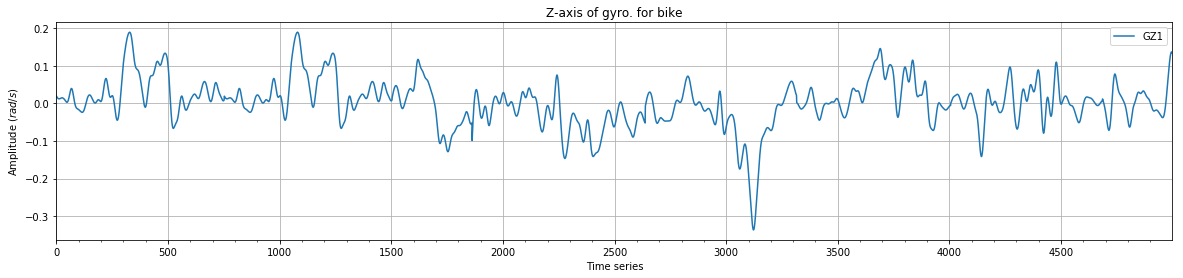

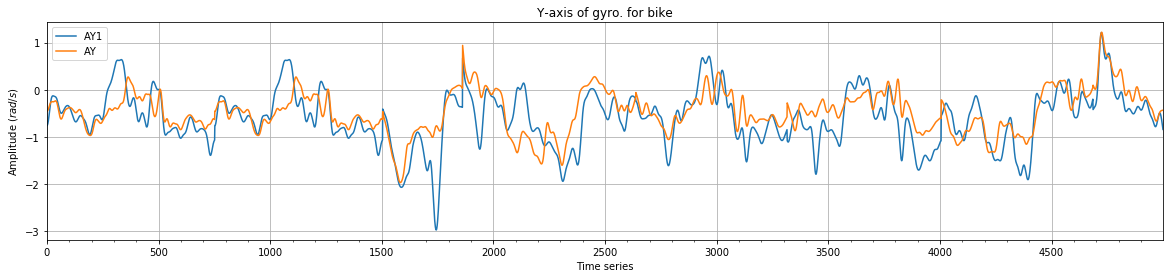

In [112]:
fig, ax = plt.subplots()
m=5000
df[['GZ1']][0:m].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df[0:m])
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)

fig, ax = plt.subplots()
df[['AY1','AY']][0:m].plot(figsize = (20,4),ax=ax, title = "Y-axis of gyro. for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df[0:m])
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)

In [110]:
car_segments, car_labels = segmentation(df, 500)
np.array(car_segments).shape



(681, 6, 500)

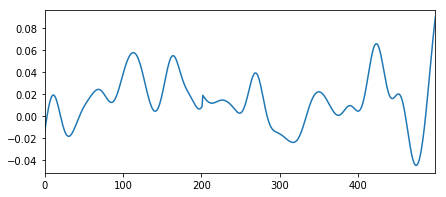

In [116]:
x = car_segments[11][2]
xx = pd.Series(x)
xx.plot(figsize = (7,3))

In [117]:
def DTWdistance(segments, ref_seg_no):
    y = segments
    DTW_list = []
    for i in range(len(segments[1])):
        x = segments[ref_seg_no][i]
        diff = loss_for_segments(y, x, i)
        DTW_list.append(diff)
    
    return DTW_list  

In [118]:
ref_seq_no = 11
dtw_data = DTWdistance(car_segments, ref_seq_no)

0 => 1.50813122878
1 => 1.54929807715
2 => 1.07346994339
3 => 1.31105452068
4 => 1.41356523444
5 => 1.16385155407
6 => 1.83261387815
7 => 1.8231586336
8 => 1.19760323942
9 => 1.13268255387
10 => 0.867493005698
11 => 0.0
12 => 1.09360305603
13 => 1.44134485651
14 => 1.83092405989
15 => 1.48717721443
16 => 1.55553711615
17 => 1.07375037808
18 => 1.2990121752
19 => 1.43861081576
20 => 1.17232070451
21 => 1.78944228893
22 => 1.65368244265
23 => 1.39021383072
24 => 1.8393804548
25 => 2.12328964795
26 => 1.76474606315
27 => 2.19294225172
28 => 2.6792196958
29 => 2.45193805673
30 => 2.17675178359
31 => 2.06308808755
32 => 2.00247796819
33 => 2.29134388639
34 => 1.38594633857
35 => 1.22427079587
36 => 2.2359907897
37 => 2.23634450286
38 => 2.88836138522
39 => 2.61253109093
40 => 2.52140816034
41 => 3.01744159101
42 => 3.02371294066
43 => 2.89709367329
44 => 2.51900079065
45 => 2.38284391833
46 => 2.37414476671
47 => 1.58230523313
48 => 1.29250473909
49 => 1.26580579571
50 => 1.21128662621
51 =

396 => 2.53066121122
397 => 2.43273422214
398 => 2.00567126078
399 => 2.59073382779
400 => 2.37007736392
401 => 2.36459827943
402 => 2.2859957602
403 => 2.29585758997
404 => 2.11777067312
405 => 2.1926310547
406 => 2.38291194149
407 => 2.36567257351
408 => 2.6415465557
409 => 2.65339786165
410 => 1.55233864479
411 => 1.53855123523
412 => 1.71593635818
413 => 1.68410487599
414 => 1.57789245851
415 => 1.68670655843
416 => 1.70825903477
417 => 1.82817104971
418 => 2.06416115428
419 => 2.16806083702
420 => 1.73615532569
421 => 1.96492170323
422 => 1.93773793259
423 => 1.9536862904
424 => 1.84067765753
425 => 1.51410449242
426 => 1.88355700572
427 => 2.9382663875
428 => 2.43630533978
429 => 2.13307589915
430 => 2.27411205842
431 => 1.96936329588
432 => 2.19827896782
433 => 2.14538123351
434 => 2.14727960279
435 => 2.72479484614
436 => 2.28303154823
437 => 1.4573920377
438 => 1.01690866402
439 => 0.911042950507
440 => 0.982813299471
441 => 0.959608197667
442 => 0.874857101103
443 => 1.194434

112 => 1.89919899012
113 => 1.39083418214
114 => 1.06370204952
115 => 1.1854081572
116 => 1.12098326641
117 => 1.54185727805
118 => 1.11487733874
119 => 0.874317593819
120 => 1.61144474142
121 => 2.84359660042
122 => 3.29980084045
123 => 3.2926618498
124 => 3.46458497826
125 => 3.55779830933
126 => 3.4055509467
127 => 3.46559652237
128 => 3.28374087095
129 => 3.38029101169
130 => 3.12539599785
131 => 0.670946513588
132 => 0.890930675291
133 => 1.6342568521
134 => 2.24361003594
135 => 2.38508637072
136 => 2.45801207729
137 => 2.69076446421
138 => 2.79314717496
139 => 3.14313516608
140 => 3.04154512565
141 => 3.16494678001
142 => 3.40477748909
143 => 2.70316966615
144 => 2.32010639463
145 => 2.06480111732
146 => 1.94823150844
147 => 2.73346521881
148 => 2.38723727079
149 => 2.10198622965
150 => 2.24212040721
151 => 2.10519953697
152 => 2.05449534051
153 => 2.33054385447
154 => 2.39321602536
155 => 2.68953113509
156 => 2.64648355989
157 => 2.84784621866
158 => 2.59515501891
159 => 2.75911

503 => 1.23627625787
504 => 1.16597411416
505 => 1.28995981694
506 => 1.03314438374
507 => 0.994413832507
508 => 0.787577664217
509 => 1.12394108047
510 => 1.08422919165
511 => 1.14696139766
512 => 1.00624270691
513 => 1.06659213787
514 => 1.3987481975
515 => 1.37920180172
516 => 1.49615287775
517 => 1.28346748317
518 => 1.11354385252
519 => 1.03522820103
520 => 1.87591043176
521 => 2.21348797974
522 => 2.44189653847
523 => 2.90371182829
524 => 2.67302888527
525 => 2.25141477432
526 => 2.31313614699
527 => 2.42196260983
528 => 2.50676981121
529 => 2.34458694532
530 => 2.48028047467
531 => 1.45063313779
532 => 1.36271730988
533 => 0.811588074478
534 => 0.568089789674
535 => 0.88863694308
536 => 1.32401349121
537 => 1.2885034965
538 => 1.70316621848
539 => 1.59193430434
540 => 1.64300552065
541 => 1.9804133406
542 => 1.64207463019
543 => 1.60193150019
544 => 1.70371578621
545 => 0.996036528447
546 => 1.40584650503
547 => 1.03000812638
548 => 0.831549222524
549 => 0.797313177806
550 => 0.

216 => 1.17764740922
217 => 1.13403096909
218 => 1.24191369511
219 => 1.02800513652
220 => 1.5107921491
221 => 1.52859318396
222 => 1.7417985589
223 => 1.79648336566
224 => 1.61863959873
225 => 1.53740768815
226 => 1.40177215559
227 => 1.37947093599
228 => 1.58348216683
229 => 2.10086794282
230 => 2.15038147472
231 => 2.05581676968
232 => 2.42978605709
233 => 2.42344557736
234 => 2.34500989468
235 => 2.31889110348
236 => 2.3771737459
237 => 2.42682527092
238 => 2.62540802876
239 => 2.06728675665
240 => 1.61809848763
241 => 1.70785814816
242 => 1.33261767353
243 => 1.32393378058
244 => 1.40993795313
245 => 1.5232280614
246 => 1.53772776648
247 => 1.46598267409
248 => 1.1425710323
249 => 1.15194037112
250 => 0.747310548567
251 => 0.80767593413
252 => 0.647856188538
253 => 0.812215634887
254 => 0.60869710115
255 => 0.83306656812
256 => 0.876804252253
257 => 0.796936388804
258 => 0.909580121977
259 => 1.10250552886
260 => 0.857483802835
261 => 0.938424025202
262 => 0.756503629237
263 => 0.

602 => 1.53421859485
603 => 1.51333449343
604 => 1.34182927523
605 => 1.37266639888
606 => 1.44498427681
607 => 1.15218422697
608 => 1.13453717353
609 => 0.903573445859
610 => 1.42724972224
611 => 1.23062944368
612 => 1.81990694251
613 => 1.8735193626
614 => 2.01330249423
615 => 1.95312590594
616 => 1.9850784123
617 => 2.09594041283
618 => 2.08891084052
619 => 1.97191793658
620 => 1.70340465338
621 => 1.50647759771
622 => 0.951669556037
623 => 0.653389328905
624 => 0.651089485195
625 => 0.745564484865
626 => 0.931310233219
627 => 1.018584652
628 => 1.13833401556
629 => 0.963437705879
630 => 0.988391685454
631 => 0.818313158022
632 => 0.927286190518
633 => 0.962257717076
634 => 0.898596193565
635 => 0.886980718755
636 => 0.794621320304
637 => 0.664596628013
638 => 0.642650575585
639 => 0.599889251826
640 => 0.64394482225
641 => 0.917883259051
642 => 1.47695551431
643 => 1.67666484639
644 => 1.66179172152
645 => 1.58882349482
646 => 1.65746331818
647 => 2.18484137368
648 => 2.16546851127

318 => 6.71594574223
319 => 6.92024411808
320 => 8.70440828073
321 => 8.75991927874
322 => 8.52698244458
323 => 7.73556731783
324 => 7.50385279202
325 => 9.74819114718
326 => 8.86409921522
327 => 7.34929305638
328 => 7.49509023481
329 => 8.45525013656
330 => 8.46470838972
331 => 7.85053706122
332 => 9.53380885782
333 => 9.67390352995
334 => 8.67908420039
335 => 5.50954703382
336 => 4.55266577926
337 => 5.6012594337
338 => 5.25192626574
339 => 8.1715997843
340 => 9.42797580466
341 => 11.9734330764
342 => 13.6145730703
343 => 11.7106299161
344 => 12.255934145
345 => 11.4757115171
346 => 9.11806221567
347 => 6.83683101401
348 => 5.77128602511
349 => 4.85290459037
350 => 5.25342991212
351 => 8.18116406202
352 => 7.55272679314
353 => 9.60788335144
354 => 10.895099292
355 => 11.7668094159
356 => 13.600244206
357 => 13.0032998791
358 => 11.5679258407
359 => 9.13853171714
360 => 7.91317210128
361 => 7.32891011319
362 => 7.67622452947
363 => 8.9739621362
364 => 6.50834911315
365 => 6.2512228822

33 => 12.8994056136
34 => 14.6880607984
35 => 12.1417556387
36 => 12.9902270138
37 => 14.8091306361
38 => 10.6958303498
39 => 11.3253303346
40 => 13.2108178938
41 => 13.4411209922
42 => 11.3436650745
43 => 5.15336543255
44 => 7.90687102748
45 => 8.7186790894
46 => 13.1661533479
47 => 8.61530923803
48 => 7.95932227949
49 => 7.38873159387
50 => 9.14810460807
51 => 10.5077315735
52 => 12.3901630366
53 => 12.1634052367
54 => 11.0887123778
55 => 10.5695280189
56 => 14.9871669303
57 => 15.0473983231
58 => 14.7100286758
59 => 14.4755472513
60 => 10.1728298085
61 => 9.54861413899
62 => 5.05496449978
63 => 5.94982992981
64 => 7.37014722359
65 => 10.1790962333
66 => 7.35347383401
67 => 8.43907520193
68 => 9.80126536268
69 => 14.1669714116
70 => 14.5808894842
71 => 11.6779415732
72 => 14.945890448
73 => 13.134739175
74 => 9.84438677078
75 => 10.3489374364
76 => 10.0153260769
77 => 11.448172886
78 => 14.6547428842
79 => 10.7161184892
80 => 11.3802851445
81 => 9.79184467013
82 => 11.9593036041
83 =

429 => 11.6062197783
430 => 9.16948111638
431 => 10.2111974731
432 => 9.19729932932
433 => 9.93445499686
434 => 8.81891845504
435 => 5.93278349261
436 => 4.32345327496
437 => 6.10258723742
438 => 11.4184715689
439 => 10.3058532431
440 => 10.9484034778
441 => 9.12573636338
442 => 8.87484434071
443 => 7.02254650455
444 => 5.0628291254
445 => 7.95241708366
446 => 11.0704574767
447 => 10.144374351
448 => 11.1634915715
449 => 9.41447799963
450 => 13.0222366816
451 => 15.2575646773
452 => 14.8746431319
453 => 14.7500696525
454 => 13.8489448762
455 => 11.8406104415
456 => 6.77856148409
457 => 5.76909221223
458 => 9.50930482832
459 => 8.60343672635
460 => 7.83094310539
461 => 8.12514977035
462 => 8.29589227447
463 => 7.63445567066
464 => 6.55251200895
465 => 9.32375154935
466 => 7.97959060737
467 => 8.23426401656
468 => 11.1763125089
469 => 12.6819726164
470 => 11.4561349698
471 => 10.8502264804
472 => 14.884463802
473 => 17.2715027908
474 => 18.5028290672
475 => 17.8885561381
476 => 17.189150

147 => 12.0246482306
148 => 10.8554567614
149 => 10.8928623742
150 => 9.02833993247
151 => 9.74909121866
152 => 7.77877608209
153 => 7.79643982404
154 => 9.66841202256
155 => 12.9437531594
156 => 13.2661470402
157 => 12.4717606834
158 => 15.782248402
159 => 14.718594126
160 => 18.9732666519
161 => 23.6640035698
162 => 21.7376121876
163 => 20.0468913117
164 => 21.4319562106
165 => 24.542781784
166 => 28.1519837113
167 => 22.7641239912
168 => 13.4923880344
169 => 5.22257255665
170 => 7.5518783618
171 => 11.2269127507
172 => 12.5813109889
173 => 16.3470414022
174 => 19.1445663266
175 => 18.3321498432
176 => 17.5065835896
177 => 20.5971669159
178 => 22.5908266186
179 => 23.7415844599
180 => 18.7564503606
181 => 11.3237723836
182 => 9.81258714757
183 => 10.9014866687
184 => 9.85867471439
185 => 7.37538913153
186 => 8.08021437524
187 => 7.46712829858
188 => 9.32816413911
189 => 6.16865587688
190 => 5.42043825306
191 => 5.81018395692
192 => 9.93604492684
193 => 10.6411195933
194 => 14.4611164

541 => 22.7562026598
542 => 22.9664149412
543 => 21.2432926697
544 => 21.2157941387
545 => 23.1606391404
546 => 26.4652908436
547 => 25.7651588681
548 => 17.8620236344
549 => 9.6633215762
550 => 5.64812681991
551 => 4.93021210461
552 => 5.87459132691
553 => 10.053165443
554 => 14.4069056105
555 => 14.0102977614
556 => 18.1293047255
557 => 20.4874673838
558 => 18.2548724356
559 => 18.9217921602
560 => 20.6940118185
561 => 23.2825872803
562 => 25.8588887806
563 => 19.1774384829
564 => 11.4813152857
565 => 4.68840606858
566 => 7.10490942074
567 => 9.22841155561
568 => 12.3566071669
569 => 15.7308016075
570 => 15.1071673482
571 => 16.4932666969
572 => 18.9958959937
573 => 19.7430502869
574 => 20.3576738036
575 => 18.9797934302
576 => 13.1535073162
577 => 7.45749278152
578 => 4.34334483097
579 => 4.25214741565
580 => 6.83073741922
581 => 10.1802050198
582 => 10.165992327
583 => 7.01212796683
584 => 9.82162279233
585 => 13.2280404376
586 => 15.4689162475
587 => 18.3193364267
588 => 18.976904

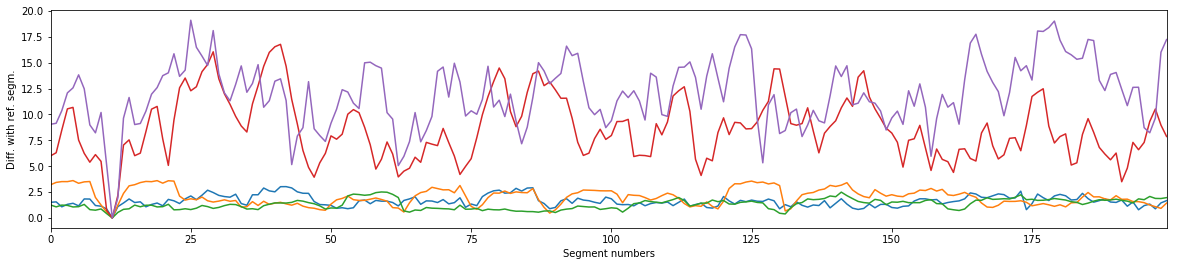

In [120]:
for i in range(5):
    loss_series_st = pd.Series(dtw_data[i])
    loss_series_st[0:200].plot(figsize =(20,4))
    plt.xlabel('Segment numbers')
    plt.ylabel('Diff. with ref. segm.')


In [121]:
path_acc = os.getcwd() + '/data/Car1109out/*/*AccelerometerLinear.csv'  
path_gyro= os.getcwd() + '/data/Car1109out/*/*Gyroscope.csv' 
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)
df1= read_files(acc_files[0], gyro_files[0], 'car')
n = len(df1)
df1 = df1[350:n-500]
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    print(acc_file)
    print(gyro_file)
    df_this = read_files(acc_file, gyro_file, 'car')
    n = len(df_this)
    print("len of this file ",df_this.shape)
    df_this = df_this[350 : n-500]
    print("len of this file ",df_this.shape)
#     print(df_this.columns)
    df1 = pd.concat([df1, df_this])
    print(df1.shape)
df1.reset_index(drop = True, inplace = True)
df1.head()

/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_19-14-12/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_19-14-12/Gyroscope.csv
len of this file  (3622, 28)
len of this file  (2772, 28)
(5544, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_18-46-25/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_18-46-25/Gyroscope.csv
len of this file  (6310, 28)
len of this file  (5460, 28)
(11004, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_18-55-22/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_18-55-22/Gyroscope.csv
len of this file  (2872, 28)
len of this file  (2022, 28)
(13026, 28)
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_19-17-04/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/Car1109out/2018-09-11_19-17-04/Gyros

,AX,AY,AZ,GX,GY,GZ,activity,orientX,orientY,orientZ,...,GY1,GZ1,mAcc,mGyro,fAX,fAY,fAZ,fGX,fGY,fGZ
0,0.151147,-0.548212,0.384174,0.014104,0.032599,0.212953,car,-2.105947,-22.135528,44.980761,...,-0.065251,0.194360,0.104629,0.008932,0.390241,0.242471,1.450791,0.390241,0.242471,1.450791
1,0.145558,-0.549001,0.315767,0.022043,0.024087,0.209872,car,-10.407979,-21.358636,44.456801,...,-0.070148,0.191415,0.081446,0.010995,-0.956881,0.785667,1.839521,-0.956881,0.785667,1.839521
2,0.131640,-0.550599,0.237944,0.029397,0.016481,0.205640,car,-33.960476,-40.116953,36.890751,...,-0.073003,0.186786,0.055786,0.013285,-0.691534,-0.422401,-0.150374,-0.691534,-0.422401,-0.150374
3,0.109519,-0.552682,0.153242,0.035762,0.010158,0.200435,car,-59.080153,73.602775,-9.470264,...,-0.073536,0.180548,0.028830,0.015792,-0.849753,0.600769,1.439380,-0.849753,0.600769,1.439380
4,0.079650,-0.554942,0.064491,0.040765,0.005447,0.194477,car,-33.272546,4.498588,-39.875493,...,-0.071550,0.172831,0.001817,0.018494,-0.610689,-0.188359,1.171801,-0.610689,-0.188359,1.171801


In [122]:
print(df1.shape)
df1.columns

(70345, 28)


Index(['AX', 'AY', 'AZ', 'GX', 'GY', 'GZ', 'activity', 'orientX', 'orientY',
       'orientZ', 'quaternionW', 'quaternionX', 'quaternionY', 'quaternionZ',
       'AX1', 'AY1', 'AZ1', 'GX1', 'GY1', 'GZ1', 'mAcc', 'mGyro', 'fAX', 'fAY',
       'fAZ', 'fGX', 'fGY', 'fGZ'],
      dtype='object')

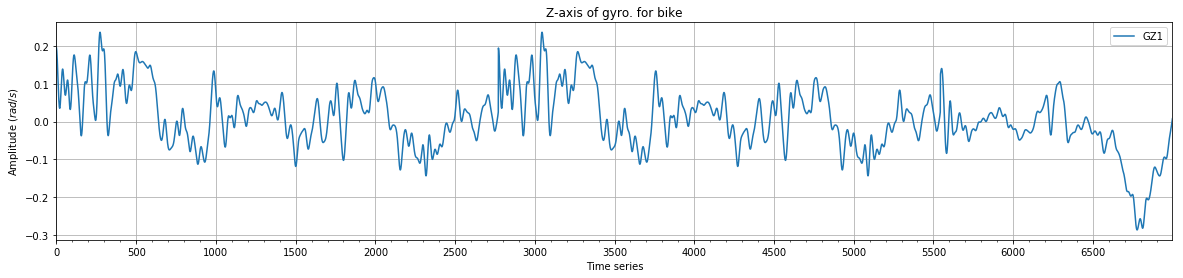

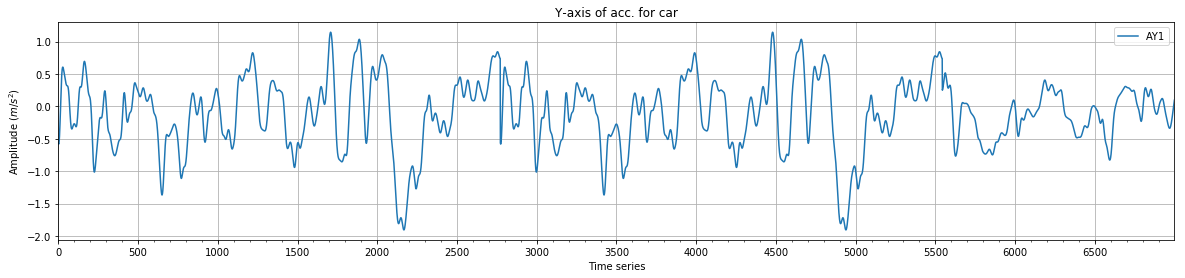

In [126]:
fig, ax = plt.subplots()
m=7000
df1[['GZ1']][0:m].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df1[0:m])
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)
fig, ax = plt.subplots()
df1[['AY1']][0:m].plot(figsize = (20,4),ax=ax, title = "Y-axis of acc. for car")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($m/s^2$)')
n = len(df1[0:m])
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)

In [124]:
car_segments1, car_labels1 = segmentation(df1, 500)
np.array(car_segments1).shape

(1397, 6, 500)

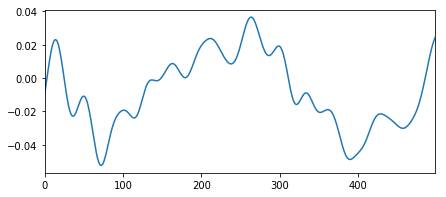

In [130]:
x = car_segments1[113][2]
xx = pd.Series(x)
xx.plot(figsize = (7,3))

In [131]:
ref_seq_no = 113
dtw_data_for_car = DTWdistance(car_segments1, ref_seq_no)

0 => 0.992982608151
1 => 0.980927794199
2 => 1.03400857999
3 => 0.913454934855
4 => 0.559497222982
5 => 0.711069088741
6 => 0.785582106009
7 => 0.608070503887
8 => 0.731881983404
9 => 0.812729788658
10 => 0.870657191894
11 => 0.752919392634
12 => 0.726488066689
13 => 0.795408208733
14 => 1.14697365384
15 => 0.991062597632
16 => 1.0718044122
17 => 1.09040861262
18 => 1.1466059616
19 => 1.21394463924
20 => 1.4256527832
21 => 1.44649278715
22 => 1.50590418118
23 => 1.19009429628
24 => 1.20703162906
25 => 1.32893712952
26 => 2.21429060667
27 => 2.41924072264
28 => 2.36089884083
29 => 2.36384807265
30 => 2.26568624525
31 => 2.1550287465
32 => 2.30684518356
33 => 2.40159472408
34 => 2.38754037813
35 => 1.94592248224
36 => 1.35855901866
37 => 0.998342453987
38 => 1.0139416343
39 => 1.08142291799
40 => 1.08415334266
41 => 1.06841150612
42 => 0.847407575098
43 => 0.919671523996
44 => 0.776429946466
45 => 0.819321761445
46 => 0.884291877704
47 => 0.903010679265
48 => 0.970947773975
49 => 1.05144

385 => 0.664166478256
386 => 0.470856879163
387 => 0.554986291635
388 => 0.569566921913
389 => 0.518724962066
390 => 0.776419550651
391 => 1.08162723816
392 => 0.964151328574
393 => 1.0597961714
394 => 1.04670747141
395 => 1.10173416767
396 => 1.02106663323
397 => 1.19308672129
398 => 1.12608814386
399 => 1.11031284999
400 => 0.722184156639
401 => 0.635240664213
402 => 0.506162386563
403 => 0.771400010825
404 => 0.407329955825
405 => 0.383110942972
406 => 0.348276214129
407 => 0.449079166171
408 => 0.553594847978
409 => 0.561626760213
410 => 0.486355121116
411 => 0.558622751819
412 => 0.531300637417
413 => 0.521023547903
414 => 0.57777478096
415 => 0.530334590461
416 => 0.377588000158
417 => 0.418680903754
418 => 0.426419161694
419 => 0.330908530345
420 => 0.356028110391
421 => 0.405055415118
422 => 0.340687029708
423 => 0.3675043376
424 => 0.358802683447
425 => 0.311410881536
426 => 0.349015510348
427 => 0.344001033752
428 => 0.330616973072
429 => 0.410539181074
430 => 0.375470622101


763 => 0.893134023906
764 => 0.833032080693
765 => 0.72356721338
766 => 0.722953997249
767 => 0.722500395549
768 => 0.679482864055
769 => 0.756723039094
770 => 0.868289878457
771 => 0.733671416218
772 => 0.840711962582
773 => 0.834276938492
774 => 1.02827876313
775 => 1.06840321771
776 => 0.919150627477
777 => 0.992788700356
778 => 0.958908685973
779 => 0.953018501187
780 => 1.02489762937
781 => 0.890762813932
782 => 0.833602142036
783 => 1.11679758745
784 => 0.727205841289
785 => 0.761148308843
786 => 0.519047192979
787 => 0.473688662751
788 => 0.554748932145
789 => 0.573467518664
790 => 0.582536259319
791 => 0.600815534416
792 => 0.637235675614
793 => 0.475654707063
794 => 0.51553771648
795 => 0.65019770964
796 => 0.553691464705
797 => 0.602335339528
798 => 0.551650950947
799 => 0.572411754068
800 => 0.487113894528
801 => 0.678375151021
802 => 0.728362599184
803 => 0.61492274298
804 => 0.764772749854
805 => 0.802102927915
806 => 0.799900805853
807 => 0.897979551699
808 => 0.780927475

1134 => 0.490324132963
1135 => 0.433220962746
1136 => 0.490248334056
1137 => 0.569550976867
1138 => 0.538545602008
1139 => 0.52763923611
1140 => 0.626592396535
1141 => 0.553402216997
1142 => 0.637160326778
1143 => 0.622077095906
1144 => 0.691512743792
1145 => 0.6500047394
1146 => 0.391155431001
1147 => 0.43729919794
1148 => 0.544393477066
1149 => 0.61917432377
1150 => 0.654120771386
1151 => 0.846846344907
1152 => 0.891675910767
1153 => 0.940733694059
1154 => 1.0161070815
1155 => 0.988843112941
1156 => 0.968473382239
1157 => 1.00179928062
1158 => 1.00375277002
1159 => 0.895638138809
1160 => 0.865020577412
1161 => 0.645478514953
1162 => 0.570116755433
1163 => 0.567334955968
1164 => 0.609642742549
1165 => 0.75507423406
1166 => 0.617696222029
1167 => 0.602950619203
1168 => 0.781702101965
1169 => 0.658583860851
1170 => 0.832455464303
1171 => 0.704733871202
1172 => 0.789785293878
1173 => 0.744707261289
1174 => 0.567651031036
1175 => 0.603811932399
1176 => 0.648383327126
1177 => 0.95524910847

110 => 0.682531962319
111 => 0.688472589839
112 => 0.420290266174
113 => 0.0
114 => 0.115441286415
115 => 0.821117240328
116 => 0.457264402314
117 => 0.603625940356
118 => 0.633318287395
119 => 0.644367796602
120 => 0.754494349354
121 => 0.895797479787
122 => 0.589907168471
123 => 0.666179406088
124 => 0.972613210919
125 => 1.49063892667
126 => 2.19215570462
127 => 2.83949563626
128 => 2.65589641836
129 => 2.85573970536
130 => 2.86107796775
131 => 2.93565934999
132 => 2.9374359578
133 => 2.63948605346
134 => 2.53437894707
135 => 2.54703443507
136 => 2.13032897425
137 => 1.18871890678
138 => 0.900028280001
139 => 0.543128423445
140 => 0.670978797007
141 => 0.477494781726
142 => 0.34252222678
143 => 0.234877436872
144 => 0.609481978906
145 => 0.500609763469
146 => 0.460612502235
147 => 0.360574362235
148 => 0.391157452055
149 => 0.457314314031
150 => 0.355128502742
151 => 0.389929995443
152 => 0.261227364974
153 => 0.436731609781
154 => 0.428137518803
155 => 0.44309621602
156 => 0.442380

491 => 0.391718426411
492 => 0.454814572692
493 => 0.367214004182
494 => 0.415997445209
495 => 0.436992536008
496 => 0.467086110618
497 => 0.469016742169
498 => 0.51289343807
499 => 0.507007798694
500 => 0.361750507422
501 => 0.310568999785
502 => 0.422548839353
503 => 0.510464891762
504 => 0.305491905696
505 => 0.215252697916
506 => 0.277102468521
507 => 0.459115330598
508 => 0.321096164775
509 => 0.420463729073
510 => 0.300264619921
511 => 0.34159233188
512 => 0.433881337693
513 => 0.534677729367
514 => 0.379938323944
515 => 0.357854963468
516 => 0.376403267808
517 => 0.631203653695
518 => 0.496385163983
519 => 1.08388510849
520 => 1.05950844965
521 => 1.04620012682
522 => 1.23119778861
523 => 1.17333879276
524 => 1.1535722285
525 => 1.31245936679
526 => 1.06815994459
527 => 1.09374702819
528 => 1.31991140369
529 => 1.38776353395
530 => 0.900361750699
531 => 1.06407051719
532 => 1.12002226754
533 => 0.815622237129
534 => 0.900832229815
535 => 0.91788467174
536 => 0.623612006212
537 =

875 => 2.2347297465
876 => 2.23817414225
877 => 2.23878248121
878 => 1.70225456505
879 => 1.45693792418
880 => 1.7971024784
881 => 1.63391502155
882 => 0.682812853331
883 => 0.317811259109
884 => 0.572441829317
885 => 0.623963144744
886 => 0.733007649036
887 => 0.853790235902
888 => 1.31448065609
889 => 1.58237064581
890 => 2.19396169065
891 => 2.16546248522
892 => 2.13823479297
893 => 2.24015947897
894 => 2.46106259872
895 => 2.20456666064
896 => 2.1571483485
897 => 2.1203698326
898 => 1.87104015679
899 => 1.86891240202
900 => 1.48738529223
901 => 0.722842982152
902 => 0.684919861341
903 => 0.886275551417
904 => 0.649146038267
905 => 0.618088137394
906 => 0.609641725793
907 => 0.741806092834
908 => 0.747126261994
909 => 0.593585042043
910 => 0.784272757852
911 => 0.981723750794
912 => 0.729813022346
913 => 0.805972796297
914 => 0.858385397404
915 => 0.799458609224
916 => 0.690957000558
917 => 0.81869097603
918 => 0.69694371342
919 => 0.398750491999
920 => 0.651468431303
921 => 0.72017

1242 => 1.86548837145
1243 => 1.58961771598
1244 => 1.52139067473
1245 => 1.56912367404
1246 => 1.75708376247
1247 => 1.59708177396
1248 => 1.66857600287
1249 => 1.53683676501
1250 => 1.62358514412
1251 => 1.82279878173
1252 => 1.59047583624
1253 => 1.40331877378
1254 => 1.39077016391
1255 => 1.47161367151
1256 => 1.30126852702
1257 => 1.20812130412
1258 => 1.0898630454
1259 => 0.9685597652
1260 => 0.949729811408
1261 => 1.02208163135
1262 => 0.963617044563
1263 => 0.817790362621
1264 => 0.934526279652
1265 => 0.877376192198
1266 => 1.04499569449
1267 => 1.14263627579
1268 => 1.02421123668
1269 => 0.938264763179
1270 => 0.866278880686
1271 => 0.842852509974
1272 => 1.00258740892
1273 => 0.786784060677
1274 => 0.945208628354
1275 => 0.814510381532
1276 => 0.611074499051
1277 => 0.711565296179
1278 => 0.763404836096
1279 => 0.706405572061
1280 => 0.637228640606
1281 => 0.3834140563
1282 => 0.417020589005
1283 => 0.656361685525
1284 => 0.312108110295
1285 => 0.383194697711
1286 => 0.43341

226 => 0.561731080451
227 => 0.571360702635
228 => 0.760459986167
229 => 0.994934795985
230 => 1.0107168674
231 => 0.974808368372
232 => 0.667196378822
233 => 0.426988013272
234 => 0.512742838838
235 => 0.719517169003
236 => 0.976723324755
237 => 0.813611264687
238 => 0.804011474344
239 => 0.98668173483
240 => 1.02309998972
241 => 0.938719209936
242 => 0.815015113393
243 => 0.715382569353
244 => 0.758050881821
245 => 1.0733398737
246 => 0.917663130491
247 => 0.727147185431
248 => 0.461434706425
249 => 0.559852611694
250 => 0.52946967573
251 => 0.65255984085
252 => 0.583887172112
253 => 0.533076159165
254 => 0.476065357342
255 => 0.509457461303
256 => 0.487574116281
257 => 0.459109118601
258 => 0.373252247317
259 => 0.33544038157
260 => 0.381527649454
261 => 0.404752185157
262 => 0.429842072332
263 => 0.492700151719
264 => 0.454013906404
265 => 0.388571517043
266 => 0.339215381767
267 => 0.390454550734
268 => 0.510299167631
269 => 0.46688946031
270 => 0.401993586987
271 => 0.47479423550

606 => 2.34743113777
607 => 2.06343310889
608 => 1.90281806126
609 => 1.98635018898
610 => 2.15220583558
611 => 2.35251376553
612 => 2.41075787618
613 => 2.02371886049
614 => 1.33487057993
615 => 1.08489487865
616 => 0.939658905925
617 => 0.991810266859
618 => 1.17124711861
619 => 1.33564789501
620 => 1.65203404782
621 => 1.51099047155
622 => 1.38704169024
623 => 1.21954713654
624 => 1.18189055519
625 => 1.41162881202
626 => 1.68613269276
627 => 1.39029397467
628 => 1.01059319704
629 => 1.07484740376
630 => 1.22065119493
631 => 1.49265281017
632 => 1.28643254141
633 => 0.963671184093
634 => 0.870545095582
635 => 0.984133338215
636 => 0.886004083526
637 => 1.06928779117
638 => 1.03234550895
639 => 0.824348913889
640 => 0.563556315219
641 => 0.72699009745
642 => 0.636688469288
643 => 0.73460341814
644 => 0.824451110429
645 => 0.792848104854
646 => 0.796524733202
647 => 0.834345117666
648 => 0.641877899744
649 => 0.603003204409
650 => 0.664529265125
651 => 0.423113503518
652 => 0.53238774

991 => 0.892230908556
992 => 0.986997012831
993 => 0.920049751795
994 => 0.615237499749
995 => 0.521214629585
996 => 0.709802768575
997 => 0.592727178194
998 => 0.588181685436
999 => 0.410677991568
1000 => 0.241488617571
1001 => 0.218614507939
1002 => 0.335696897404
1003 => 0.447741596413
1004 => 0.642723469536
1005 => 0.617520045902
1006 => 0.402900144022
1007 => 0.340089205319
1008 => 0.435032773119
1009 => 0.374008630079
1010 => 0.440866632887
1011 => 0.481896372695
1012 => 0.557119584879
1013 => 0.634023794075
1014 => 0.475261807745
1015 => 0.256019934819
1016 => 0.343405132499
1017 => 0.542949801595
1018 => 0.471567388795
1019 => 0.432555707804
1020 => 0.353804999823
1021 => 0.459358422319
1022 => 0.463907693919
1023 => 0.452304638402
1024 => 0.320836543153
1025 => 0.391761237909
1026 => 0.414437301832
1027 => 0.424490115989
1028 => 0.457190578326
1029 => 0.383466367488
1030 => 0.356720294868
1031 => 0.385488528343
1032 => 0.449705887716
1033 => 0.512510429176
1034 => 0.3411518307

1354 => 0.972274695208
1355 => 0.781196283328
1356 => 0.796486277366
1357 => 0.941074908635
1358 => 1.24279544589
1359 => 1.35118138056
1360 => 1.1457994507
1361 => 0.870181725575
1362 => 0.785566048746
1363 => 0.797871589577
1364 => 0.697384513499
1365 => 0.512246221255
1366 => 0.502827735895
1367 => 0.711017850516
1368 => 0.28829530184
1369 => 0.367523767832
1370 => 0.32280498269
1371 => 0.337115653112
1372 => 0.477508941895
1373 => 0.4412668732
1374 => 0.55032933844
1375 => 0.434542815019
1376 => 0.382640601385
1377 => 0.48075801484
1378 => 0.482776394082
1379 => 0.488799281997
1380 => 0.279824462829
1381 => 0.319321148794
1382 => 0.575900598167
1383 => 0.553533472078
1384 => 0.647865433485
1385 => 0.412698237826
1386 => 0.46952846115
1387 => 0.569925012755
1388 => 0.603674034306
1389 => 0.569114249597
1390 => 0.344740141802
1391 => 0.400019663024
1392 => 0.519573905078
1393 => 0.599114027718
1394 => 0.642805804588
1395 => 0.57718961042
1396 => 0.472343278093
0 => 6.15863632659
1 =>

353 => 9.60685498299
354 => 10.566427091
355 => 9.11259797687
356 => 6.94037975697
357 => 5.77631413345
358 => 4.35029192482
359 => 3.51897556288
360 => 4.96939709221
361 => 7.11495826824
362 => 8.00850773393
363 => 7.24252674781
364 => 4.91835750177
365 => 4.43900852304
366 => 5.80970050265
367 => 7.40711071632
368 => 5.82400185256
369 => 3.72861295963
370 => 4.12587840066
371 => 4.8943969856
372 => 4.3621184382
373 => 4.17850542771
374 => 4.67819031945
375 => 5.88779559823
376 => 7.22255286573
377 => 6.65325756441
378 => 4.02747094951
379 => 2.22639103267
380 => 3.06724018667
381 => 5.19695164217
382 => 6.92803893509
383 => 7.68087523392
384 => 8.50339974299
385 => 8.59953757992
386 => 6.59949562791
387 => 6.54240482151
388 => 7.80501119482
389 => 9.63286623783
390 => 11.4835364861
391 => 8.50922452978
392 => 6.26499440583
393 => 6.14984052365
394 => 6.68326070088
395 => 4.57183916811
396 => 4.0785777668
397 => 4.11649979414
398 => 5.53385364155
399 => 7.76468345114
400 => 8.18827055

745 => 5.06077054561
746 => 6.05023670687
747 => 7.60301809344
748 => 7.8376380827
749 => 7.29911511585
750 => 6.34605407617
751 => 7.18802090955
752 => 8.7648812392
753 => 8.8185239005
754 => 5.81623353497
755 => 3.69718117357
756 => 2.95730816538
757 => 2.35768862939
758 => 3.90066051389
759 => 5.13225688156
760 => 4.4864606178
761 => 4.99220661155
762 => 4.77814696346
763 => 4.6652825152
764 => 5.87385259408
765 => 5.47168061676
766 => 3.23593275906
767 => 3.22082640847
768 => 4.34171703381
769 => 6.1770750045
770 => 5.1418568108
771 => 7.24403076815
772 => 10.5092280216
773 => 11.6140401439
774 => 12.1129294751
775 => 11.5634235156
776 => 9.6437662178
777 => 8.73085579404
778 => 8.4214275118
779 => 8.86123940559
780 => 12.0318089854
781 => 11.451845876
782 => 8.69368907089
783 => 6.32671682658
784 => 4.79286942901
785 => 3.8938108878
786 => 4.44730831361
787 => 5.39013507635
788 => 5.44379880193
789 => 3.66058645196
790 => 3.11495236158
791 => 3.235935198
792 => 3.66381666226
793 =

1131 => 6.07373634486
1132 => 4.99682127527
1133 => 5.38885079266
1134 => 5.7773025539
1135 => 6.2151528017
1136 => 7.25936079305
1137 => 6.4202114115
1138 => 5.96224653468
1139 => 5.53926265255
1140 => 5.11876988673
1141 => 6.18678628476
1142 => 6.02578392459
1143 => 7.06946762891
1144 => 5.74176055705
1145 => 5.57670249708
1146 => 7.63683351633
1147 => 7.53337791446
1148 => 5.7826864625
1149 => 6.34012146554
1150 => 7.69925666077
1151 => 7.32864191879
1152 => 6.78589685962
1153 => 6.26748256004
1154 => 6.74184860707
1155 => 8.12918341673
1156 => 7.47785870547
1157 => 5.48955520963
1158 => 4.25555141043
1159 => 4.15220615074
1160 => 3.95607767947
1161 => 4.34407769065
1162 => 6.24518984403
1163 => 6.21321431888
1164 => 5.4268521149
1165 => 5.33567225061
1166 => 5.6280130197
1167 => 6.53270230979
1168 => 8.82712342837
1169 => 8.33128418383
1170 => 8.11649328442
1171 => 8.57993957135
1172 => 6.80261489007
1173 => 4.32219950803
1174 => 3.39467855195
1175 => 3.49623966161
1176 => 5.699748

120 => 9.73325056524
121 => 9.98910677991
122 => 8.60320072667
123 => 5.86272385353
124 => 4.27909418306
125 => 5.62711928296
126 => 6.56419466039
127 => 5.38359928268
128 => 4.49506869502
129 => 7.07780526174
130 => 9.43286598815
131 => 9.36329218138
132 => 9.2559409468
133 => 9.02085829853
134 => 11.1641870211
135 => 11.1806738615
136 => 10.0193632929
137 => 9.8592072341
138 => 9.41903143768
139 => 7.80185142631
140 => 7.2968854276
141 => 9.05714068283
142 => 11.0529519623
143 => 11.3247270356
144 => 5.98631212233
145 => 4.87349951489
146 => 7.01282454574
147 => 7.99622686608
148 => 6.43601490799
149 => 5.08945100914
150 => 8.48471619014
151 => 11.1304748851
152 => 10.1903843511
153 => 6.43157129097
154 => 7.38672706442
155 => 10.1904535738
156 => 11.003300356
157 => 9.02459616085
158 => 9.54442871438
159 => 10.1739996945
160 => 9.85385677651
161 => 9.13762375466
162 => 8.95388180712
163 => 7.66548613386
164 => 11.1364592948
165 => 13.3234753391
166 => 16.2401105781
167 => 14.4851840

513 => 9.38403077179
514 => 12.0866719704
515 => 13.1694592216
516 => 10.9718191977
517 => 12.422465142
518 => 15.1512521458
519 => 15.4623843783
520 => 13.7947298285
521 => 13.1651899208
522 => 12.2790666991
523 => 10.5188011522
524 => 6.98529667259
525 => 5.51897416611
526 => 5.77594505473
527 => 7.19765146114
528 => 10.3597057779
529 => 12.3220853757
530 => 11.1465406191
531 => 12.1483348719
532 => 13.1499628873
533 => 15.3875997436
534 => 13.7279140665
535 => 11.2221665972
536 => 10.0661789287
537 => 11.0362867622
538 => 11.0120914844
539 => 12.257497601
540 => 13.2264666322
541 => 13.035005521
542 => 10.6717781616
543 => 10.9534493945
544 => 11.1951047267
545 => 9.1810407553
546 => 6.39081067193
547 => 8.49626714534
548 => 12.3318063864
549 => 15.7336587312
550 => 13.7414879683
551 => 11.5519586971
552 => 12.0051765329
553 => 12.9858816688
554 => 13.9801881483
555 => 13.1210401135
556 => 11.1983904078
557 => 7.70796118486
558 => 5.96853798958
559 => 7.05779881872
560 => 7.21149018

905 => 12.1003935227
906 => 10.147933097
907 => 9.17335339601
908 => 8.49833079071
909 => 7.56489161466
910 => 8.08515598052
911 => 9.87848276428
912 => 12.3915045125
913 => 13.6651368889
914 => 12.7551838959
915 => 13.9668005783
916 => 16.2304519564
917 => 14.324015938
918 => 13.6637240546
919 => 12.1918292557
920 => 11.5217613966
921 => 11.3966967501
922 => 9.60114982827
923 => 7.20690254541
924 => 8.27872707071
925 => 14.2135701992
926 => 14.5719272471
927 => 13.8609344944
928 => 11.9681281355
929 => 11.3461121801
930 => 13.1274754516
931 => 15.8886886711
932 => 17.4388206744
933 => 15.7911717194
934 => 13.7671089048
935 => 12.3361121075
936 => 11.4022907851
937 => 9.52151932144
938 => 6.90017243365
939 => 4.38734267394
940 => 3.32167755431
941 => 3.37062623413
942 => 4.19475637304
943 => 6.33862841418
944 => 7.74773842553
945 => 7.82223798023
946 => 6.50285263133
947 => 7.8237904993
948 => 10.5137740899
949 => 8.20696089154
950 => 8.03977484282
951 => 10.1449428493
952 => 12.722597

1285 => 14.136891449
1286 => 13.2626576656
1287 => 12.9869314702
1288 => 13.775546208
1289 => 15.9120484634
1290 => 14.0168410237
1291 => 11.5797451762
1292 => 13.2255281732
1293 => 14.2375003372
1294 => 12.7643874336
1295 => 11.5014176873
1296 => 11.3847644354
1297 => 9.56448431097
1298 => 8.67660999046
1299 => 6.29196849931
1300 => 6.52880855649
1301 => 9.19130592902
1302 => 10.1637044703
1303 => 7.5937908748
1304 => 7.0776302196
1305 => 10.4452726633
1306 => 13.6522137788
1307 => 10.4738149921
1308 => 7.26638341704
1309 => 8.86861596939
1310 => 9.93467228592
1311 => 8.29493686763
1312 => 5.79976745005
1313 => 8.93556045185
1314 => 11.5668151463
1315 => 11.1301738657
1316 => 9.64022585765
1317 => 11.2909490239
1318 => 13.8714165013
1319 => 15.9394448756
1320 => 14.0073193951
1321 => 12.370480014
1322 => 10.7796749704
1323 => 8.02005456533
1324 => 8.51495825274
1325 => 9.7114506402
1326 => 12.1738315297
1327 => 10.925493841
1328 => 10.9637192763
1329 => 13.769264469
1330 => 13.4521698

281 => 1.30062170555
282 => 1.00310655939
283 => 1.04848992971
284 => 1.16032265583
285 => 1.83186906292
286 => 1.58306599829
287 => 1.1459308475
288 => 1.87035251956
289 => 1.55141044668
290 => 1.36210817954
291 => 1.75432462389
292 => 1.28076850555
293 => 6.12370742345
294 => 5.36887066177
295 => 5.130498821
296 => 5.60588986877
297 => 5.44411292613
298 => 5.31656041613
299 => 4.92726065772
300 => 4.73524806972
301 => 5.33047149179
302 => 5.61724460684
303 => 1.63935015503
304 => 1.25345804208
305 => 1.53007446955
306 => 1.48502196595
307 => 0.899527104913
308 => 1.50568527858
309 => 1.41633061906
310 => 1.17466319795
311 => 0.896064041689
312 => 1.00279790382
313 => 1.48532016073
314 => 1.46034453257
315 => 2.01244290279
316 => 1.61029461208
317 => 1.58012526867
318 => 2.31999552591
319 => 2.41392258242
320 => 2.29882649228
321 => 2.8619501608
322 => 2.42210860453
323 => 3.056259465
324 => 3.41101204952
325 => 3.38816060912
326 => 3.85194029725
327 => 3.41617926903
328 => 3.42356937

674 => 1.64256925746
675 => 2.15632790891
676 => 1.29953815446
677 => 0.936359894821
678 => 1.7115226158
679 => 1.78264430848
680 => 1.85232558754
681 => 1.95810758883
682 => 1.18722634425
683 => 1.8268908504
684 => 2.23239498519
685 => 1.64471696245
686 => 1.6592845842
687 => 1.73837281592
688 => 1.20761393925
689 => 2.23788083941
690 => 1.64371694689
691 => 1.06897489621
692 => 1.29609540476
693 => 1.17695321739
694 => 1.72265383153
695 => 1.6887597337
696 => 1.67668523961
697 => 1.67048089554
698 => 1.21376135455
699 => 1.47348608789
700 => 1.72752420531
701 => 1.87988773659
702 => 1.79585887388
703 => 1.49397292595
704 => 1.36189635733
705 => 1.00060867392
706 => 1.21381332223
707 => 1.34352666565
708 => 1.24908152908
709 => 1.26064503293
710 => 1.24998708614
711 => 1.60298013111
712 => 2.75162133208
713 => 3.09523306948
714 => 3.0753530933
715 => 2.93669449491
716 => 3.15433524437
717 => 2.99147861238
718 => 3.52668051654
719 => 3.4565716672
720 => 3.34485709296
721 => 3.220989996

1064 => 1.10149636994
1065 => 1.20184318399
1066 => 1.19877951405
1067 => 1.01950792127
1068 => 1.07540923424
1069 => 1.31731095255
1070 => 1.54551213694
1071 => 1.06633283299
1072 => 0.793276250336
1073 => 1.30347567232
1074 => 0.973626348035
1075 => 0.97249868837
1076 => 0.866323703346
1077 => 0.78984743803
1078 => 1.39273666106
1079 => 1.19711206903
1080 => 1.1274940713
1081 => 1.1902392317
1082 => 1.37317236315
1083 => 1.39420395975
1084 => 1.02191763228
1085 => 1.3613788013
1086 => 1.27466744422
1087 => 1.08501828912
1088 => 1.9798369082
1089 => 2.28515152319
1090 => 2.21107467204
1091 => 2.17185366837
1092 => 2.34392040993
1093 => 3.03508251254
1094 => 2.93324661766
1095 => 3.05279010133
1096 => 2.79691557589
1097 => 2.70192698514
1098 => 2.78969588084
1099 => 1.89266481846
1100 => 1.75090260232
1101 => 2.36787351338
1102 => 1.89653379513
1103 => 1.78704506645
1104 => 1.99513397106
1105 => 2.57046076979
1106 => 2.8523478286
1107 => 2.78576637733
1108 => 2.67759482917
1109 => 3.06

In [132]:
print(np.array(dtw_data).shape)
print(np.array(dtw_data_for_car).shape)


(6, 681)
(6, 1397)


In [133]:

train1 = dtw_data                 #dtw feature vector for bike
label1 = [1]*len(train1[0])       #putting lebel = 1 to all bike samples

train2 = dtw_data_for_car         #dtw feature vector for car
label2 = [0]*len(train2[0])       #putting lebel = 1 to all car samples

train = [x+y for x,y in zip(train1, train2)]  #putting both traing data into one  

label = label1 + label2  #putting both lables into one label

train = [*zip(*train)]   #transpose of traing data



In [148]:
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=RANDOM_SEED)

In [149]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))


1662
1662
416
416


In [150]:
from sklearn import svm
svm_clf = svm.SVC(kernel='linear', C=1)

In [151]:
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=5)
print(svm_scores, svm_scores.mean(), svm_scores.std())

[ 0.96696697  0.98198198  0.96996997  0.96686747  0.95166163] 0.967489604044 0.00966815547294


In [158]:
# apply model to test set
svm_clf.fit(X_train, y_train)
svm_predict_y = svm_clf.predict(X_test)


In [159]:
# obtain accuracy score
testscore = accuracy_score(y_test, svm_predict_y)
print("Accuracy score on test set: %6.3f" % testscore)

Accuracy score on test set:  0.976


In [154]:
for i in range(len(predict_y)):
    print(y_test[i], " ", predict_y[i])
    print("-----")

1   1
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
1   1
-----
0   0
-----
1   1
-----
0   0
-----
0   0
-----
1   1
-----
1   1
-----
0   0
-----
1   1
-----
1   1
-----
1   1
-----
1   1
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
1   1
-----
0   0
-----
1   1
-----
0   0
-----
1   1
-----
0   0
-----
1   1
-----
0   0
-----
1   1
-----
1   1
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
1   1
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
1   1
-----
0   0
-----
1   1
-----
0   0
-----
0   0
-----
1   1
-----
1   1
-----
1   1
-----
0   0
-----
1   1
-----
1   1
-----
1   1
-----
0   0
-----
0   0
-----
0   0
-----
1   1
-----
0   0
-----
0   0
-----
1   1
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
1   0
-----
0   0
-----
0   0
-----
0   0
-----
1   1
-----
1   1
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
0   0
-----
1   1
-----
0   0
-----
1   1
-----
1   1
-----
0   0
-----
0   

In [160]:

# train a random forest
clf = RandomForestClassifier(n_estimators=200)

In [161]:
# get the 5-fold cross-validation score
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores, scores.mean(), scores.std())

[ 0.99099099  0.99099099  0.98198198  0.98493976  0.96978852] 0.983738448528 0.0078016354961


In [162]:

# apply model to test set
clf.fit(X_train, y_train)
rf_predict_y = clf.predict(X_test)
print(rf_predict_y)

[1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0
 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 1
 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1
 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0
 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0
 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1
 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1
 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1
 0 0 0 0 1 0 0 1 1]


In [147]:

# obtain accuracy score
testscore = accuracy_score(y_test, rpredict_y)
print("Accuracy score on test set: %6.3f" % testscore)

Accuracy score on test set:  0.976
